# Radar Signal Generation


We first import the required modules of the library.

In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, '../src')

import numpy as np

import matplotlib.pyplot as plt

from deepverse import ParameterManager
from deepverse import Dataset
from deepverse.wireless.Waveform import FMCW

from pprint import pprint

## FMCW Waveform

In the following, we present the FMCW (frequency modulated continuous wave) radar waveform generation. In essence, the following equation can be implemented given the path information, including
- angles of arrival & departure
- time of arrival (path delay)
- Doppler shift

The FMCW waveform can be written as

$vel[t] = \frac{d_v[t] \cdot t}{ c} $

$acc[t] = \frac{d_a[t] \cdot t^2}{2c} $

$ \tau'[t] = \tau + vel[t] + acc[t] $

$ f_{IF}[t] = S \tau'[t] $ 

$ \phi_{IF} = (f_0 - 0.5 S \tau'[t])  \tau'[t]$

$ y[t] = a_l e^{j 2 \pi (f_{IF}[t] t + \phi_{IF})}$

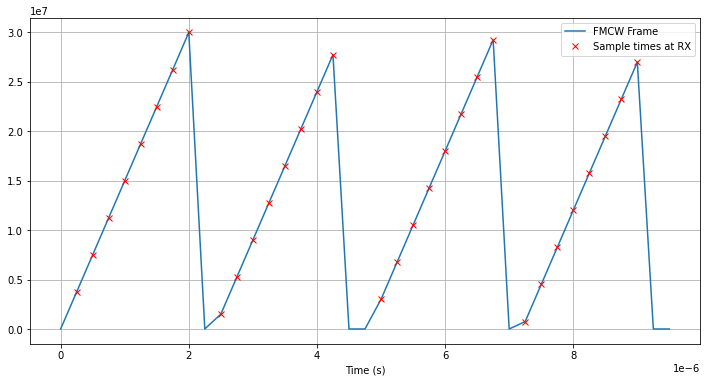

In [154]:
n_chirp = 4
n_samples_per_chirp = 8
chirp_slope = 15e12
f_0 = 28e9
Fs=4e6
T_period = n_samples_per_chirp/Fs*1.2
lightspeed = 3e8
T_chirp = n_samples_per_chirp/Fs
T_pause = T_period - T_chirp

ramp_duration = n_samples_per_chirp / Fs
t = np.arange(0, T_period * n_chirp, 1/Fs)

t_chirp_slope = (t % T_period)
t_chirp_slope[t_chirp_slope>ramp_duration] = 0
chirps = t_chirp_slope * chirp_slope

plt.figure(figsize=(12, 6))
plt.plot(t, chirps, label='FMCW Frame')
plt.plot(t[t_chirp_slope>0], chirps[t_chirp_slope>0], 'rx', label='Sample times at RX')

plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()

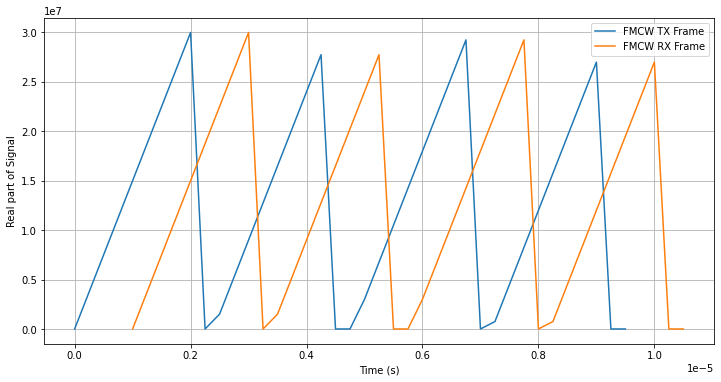

In [156]:
ch_time_delay = 1e-6
t_rx = t + ch_time_delay

t_rx_new = np.arange(0, T_period * n_chirp + ch_time_delay, 1/Fs)
t_rx_new_norm = t_rx_new-ch_time_delay
t_chirp_slope_new = t_rx_new_norm % T_period
t_chirp_slope_new[t_chirp_slope_new>ramp_duration] = 0
t_chirp_slope_new[t_rx_new_norm<0] = 0
chirps_rx = t_chirp_slope_new * chirp_slope

plt.figure(figsize=(12, 6))
plt.plot(t, chirps, label='FMCW TX Frame')
plt.plot(t_rx, chirps, label='FMCW RX Frame')
# plt.plot(t_rx_new, chirps_rx, label='FMCW RX Frame')
#plt.plot(t[t_chirp_slope>0], chirps[t_chirp_slope>0], 'rx', label='Samples at RX')

plt.xlabel('Time (s)')
plt.ylabel('Real part of Signal')
plt.legend()
plt.grid(True)
plt.show()

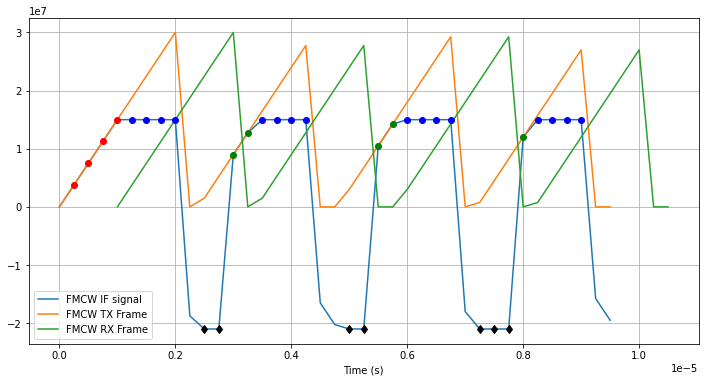

In [161]:
freq_diff = chirps-chirps_rx[:len(t)]

plt.figure(figsize=(12, 6))
plt.plot(t, freq_diff, label='FMCW IF signal')
# plt.plot(t[t_chirp_slope>0], freq_diff[t_chirp_slope>0], 'rx', label='IF samples at RX')
plt.plot(t, chirps, label='FMCW TX Frame')
plt.plot(t_rx, chirps, label='FMCW RX Frame')

chirp_sample_idx = t_chirp_slope>0
t_chirp_time = t[chirp_sample_idx]
t_chirp_time_rx = t_rx[chirp_sample_idx]

t_diff = (t_chirp_time_rx - t_chirp_time)

constant_filter = (t_chirp_time%T_period) <= (T_chirp)

# # First part of the signal
initial_part =  constant_filter & (t_chirp_time < t_chirp_time_rx[0])
t_no_rx = t_chirp_time[initial_part]
t_chirp_constant = t_chirp_time[initial_part]
freq_diff_constant = (t_no_rx%T_period) * chirp_slope
plt.plot(t_chirp_constant, freq_diff_constant, 'ro')

not_initial_part = ~initial_part
constant_pos_filter = constant_filter & not_initial_part & ((t_chirp_time%T_period) >= (ch_time_delay%T_period))
t_diff = t_diff[constant_pos_filter] % T_period
t_chirp_constant = t_chirp_time[constant_pos_filter]
freq_diff_constant = t_diff * chirp_slope
plt.plot(t_chirp_constant, freq_diff_constant, 'bo')

no_rx_filter =  constant_filter & not_initial_part & ((t_chirp_time%T_period) < (ch_time_delay%T_period)) & ((t_chirp_time%T_period) > (ch_time_delay%T_period - T_pause))
t_no_rx = t_chirp_time[no_rx_filter]
t_chirp_constant = t_chirp_time[no_rx_filter]
freq_diff_constant = (t_no_rx%T_period) * chirp_slope
plt.plot(t_chirp_constant, freq_diff_constant, 'go')

neg_rx_filter =  constant_filter & not_initial_part & ((t_chirp_time%T_period) < (ch_time_delay%T_period)) & ((t_chirp_time%T_period) < (ch_time_delay%T_period - T_pause))
t_diff_neg = (t_chirp_time_rx - t_chirp_time - np.ceil(ch_time_delay/T_period)*T_period)
t_diff_neg = t_diff_neg[neg_rx_filter]
t_neg_rx = t_chirp_time[neg_rx_filter]
t_chirp_constant = t_chirp_time[neg_rx_filter]
freq_diff_constant = t_diff_neg * chirp_slope
plt.plot(t_chirp_constant, freq_diff_constant, 'kd')
# plt.plot(t_chirp_neg, freq_diff_neg, 'bo')


plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()